# Tutorial 5: Vertical Spatial Transcriptomics Integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in vertical integration. Here we take mouse breast cancer sample1 as example. The ST data were generated from our lab (Jinmiao Chen's Lab). Before inputting the model, alignment algorithm was implemented to align sections 1 and 2. 

Please note that aligned position information must be saved in adata.obsm['spatial'] before running the model.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
from DeepST import DeepST

In [3]:
# set random seed
random_seed = 50 
DeepST.fix_seed(random_seed)

In [4]:
# Run device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [5]:
# the number of clusters
n_clusters = 10

In [6]:
# read data
file_fold = '/home/yahui/Yahui/Projects/data/S1_A1_S3_A1/' #please replace it with the download path
adata = sc.read_h5ad(file_fold + 'filtered_feature_bc_matrix.h5ad')
adata.var_names_make_unique()

## Plotting aligned image

Sample labels are saved in adata.obs['data']. 'S1' denotes Section1 while 'S3' denotes Section 2

Text(0.5, 1.0, 'Aligned image')

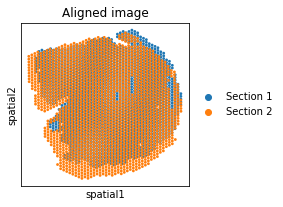

In [7]:
plt.rcParams["figure.figsize"] = (3, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial',
                color='data',
                show=False)
ax.set_title('Aligned image')
#ax.axis('off')

In [8]:
# preprocessing for ST data
DeepST.preprocess(adata)

# build graph
DeepST.construct_interaction(adata)
DeepST.add_contrastive_label(adata)

In [9]:
# get features
DeepST.get_feature(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 3818 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a'

In [11]:
# define and train model
model = DeepST.Train(adata, device=device)
adata.obsm['emb'] = model.train()

Begin to train ST data...


100%|█████████████████████████████████████████| 600/600 [00:07<00:00, 84.03it/s]

Optimization finished for ST data!


In [12]:
# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, sample='multiple', refinement=False)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [13]:
adata.obs['data'].unique()

['Section 1', 'Section 2']
Categories (2, object): ['Section 1', 'Section 2']

In [14]:
adata

AnnData object with n_obs × n_vars = 3818 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'mclust', 'label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'

## Plotting UMAP before and after batch effect correction

2022-08-19 12:38:15.037844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 12:38:15.968304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yahui/cuda-10.0/lib64:/home/yahui/cuda-10.0/mylib/lib64:/home/yahui/cuda-10.2/lib64:/tools/R/R-4.0.3_openblas/R-4.0.3/lib:
2022-08-19 12:38:15.968720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY

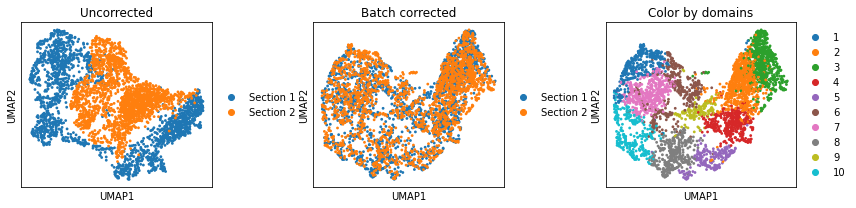

In [15]:
fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))

### Plotting UMAP before batch effect correction
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
    
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Uncorrected', 
                  ax = ax_list[0],
                  show=False)

### Plotting UMAP after batch effect correction
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color='data', 
           ax=ax_list[1], 
           title='Batch corrected', 
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(adata, color='label', ax=ax_list[2], title='Color by domains', show=False)

plt.tight_layout(w_pad=0.02)

## Plotting joint clustering results

For mouse breast cancer sample1, we manually annotated section2 according to H&E image. 
The ground truth labels are avaialbe at https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.  

/tmp/ipykernel_50156/3602074285.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_section2.obs['ground_truth'] = df_meta_layer.values


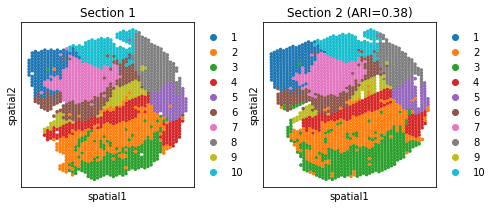

In [16]:
from sklearn import metrics
### Splitting adata into Section 1 and Section 2
adata_section1 = adata[adata.obs['data']=='Section 1', :]
adata_section2 = adata[adata.obs['data']=='Section 2', :]

### read ground truth
df_meta = pd.read_csv('/home/yahui/Yahui/Projects/data/S3_A1/metadata.tsv', sep='\t')
df_meta_layer = df_meta['ground_truth']
adata_section2.obs['ground_truth'] = df_meta_layer.values

### calculate ARI score
ARI = metrics.adjusted_rand_score(adata_section2.obs['label'], adata_section2.obs['ground_truth'])

fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pl.embedding(adata_section1, 
                basis='spatial', 
                color='label',
                show = False,
                s=50,
                title='Section 1',
                ax = ax_list[0])

sc.pl.embedding(adata_section2, 
                basis='spatial', 
                color='label',
                show = False,
                s=50,
                title = ['Section 2 (ARI=%.2f)'%ARI],
                ax = ax_list[1])

plt.tight_layout(w_pad=0.2)